In [1]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.functions import col, count, max, min, sum, when, mean, mode
import seaborn as sns
import pandas as pd
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
import os, sys

In [2]:
import os
import sys

os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable
os.environ['HADOOP_HOME'] = 'D:\hadoop\hadoop-3.4.0'
os.environ['hadoop.home.dir'] = 'D:\hadoop\hadoop-3.4.0'

In [3]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [4]:
spark = SparkSession.builder.appName('Mental Health') \
         .getOrCreate()

In [5]:
train_data = spark.read.csv('data/train.csv', header=True, inferSchema=True)
test_data = spark.read.csv('data/test.csv', header=True, inferSchema=True)

1. **id**: Unique identifier for each participant in the dataset.
2. **Name**: The participant's full name or chosen identifier.
3. **Gender**: The gender of the participant.
4. **Age**: The participant's age in years.
5. **City**: The city where the participant currently resides.
6. **Working Professional or Student**: Indicates if the participant is a working professional or a student.
7. **Profession**: The specific field or occupation of the participant, if applicable.
8. **Academic Pressure**: Measures the participant’s perceived academic-related stress (e.g., from exams or assignments).
9. **Work Pressure**: Measures the participant’s perceived work-related stress (e.g., deadlines or workload).
10. **CGPA**: The participant's cumulative grade point average (if a student).
11. **Study Satisfaction**: Level of satisfaction with academic studies, often rated on a scale (e.g., from very dissatisfied to very satisfied).
12. **Job Satisfaction**: Level of satisfaction with current job, often rated on a scale.
13. **Sleep Duration**: Average number of hours of sleep the participant gets each night.
14. **Dietary Habits**: General pattern of the participant's diet.
15. **Degree**: The highest level of academic degree obtained by the participant.
16. **Have you ever had suicidal thoughts?**: Indicates whether the participant has ever experienced suicidal thoughts.
17. **Work/Study Hours**: Average number of hours the participant spends on work or study activities daily.
18. **Financial Stress**: Level of stress experienced by the participant due to financial issues.
19. **Family History of Mental Illness**: Indicates if there is a family history of mental health conditions.
20. **Depression**: Measures or indicates the presence of depression in the participant (e.g., based on self-report or diagnostic criteria).

## First view of data

In [6]:
column_renaming = {
    'Gender': 'Gender',
    'Age': 'Age',
    'Working Professional or Student': 'Status',
    'Profession': 'Profession',
    'Academic Pressure': 'Acad_Pressure',
    'Work Pressure': 'Work_Pressure',
    'CGPA': 'CGPA',
    'Study Satisfaction': 'Study_Sat',
    'Job Satisfaction': 'Job_Sat',
    'Sleep Duration': 'Sleep_Dur',
    'Dietary Habits': 'Diet_Habits',
    'Degree': 'Degree',
    'Have you ever had suicidal thoughts ?': 'Suicidal_Thoughts',
    'Work/Study Hours': 'Work_Study_Hours',
    'Financial Stress': 'Fin_Stress',
    'Family History of Mental Illness': 'Fam_Mental_Illness',
    'Depression': 'Depression'
}

In [7]:
train_data = train_data.withColumnsRenamed(column_renaming)
test_data = test_data.withColumnsRenamed(column_renaming)

In [8]:
def data_info(data):

    # Data types
    typs = spark.createDataFrame(train_data.dtypes, ['features', 'type'])

    # Null count
    num_nulls = train_data.select(*[F.sum(col(i).isNull().cast('int')).alias(i) for i in train_data.columns])
    num_nulls = num_nulls.unpivot('Age', num_nulls.columns, 'features', 'num_nulls').drop('Age')

    # Max value
    numeric_columns = [i for i, t in data.dtypes if t != 'string']

    max_values = data.select(*[max(col(i)).alias(i) for i in numeric_columns])
    max_values = max_values.unpivot('Age', max_values.columns, 'features', 'max_val').drop('Age')

    # Min value
    min_values = data.select(*[min(col(i)).alias(i) for i in numeric_columns])
    min_values = min_values.unpivot('Age', min_values.columns, 'features', 'min_val').drop('Age')

    # N unique
    nunique = data.select(*[F.count_distinct(col(i)).alias(i) for i in data.columns])
    nunique = nunique.unpivot('Age', nunique.columns, 'features', 'n_unique').drop('Age')

    return typs.join(num_nulls, on='features', how='left') \
                 .join(max_values, on='features', how='left') \
                 .join(min_values, on='features', how='left') \
                 .join(nunique, on='features', how='left')

In [9]:
data_info(train_data).show()

+------------------+------+---------+--------+-------+--------+
|          features|  type|num_nulls| max_val|min_val|n_unique|
+------------------+------+---------+--------+-------+--------+
|                id|   int|        0|140699.0|    0.0|  140700|
|              Name|string|        0|    NULL|   NULL|     422|
|            Gender|string|        0|    NULL|   NULL|       2|
|               Age|double|        0|    60.0|   18.0|      43|
|              City|string|        0|    NULL|   NULL|      98|
|            Status|string|        0|    NULL|   NULL|       2|
|        Profession|string|    36630|    NULL|   NULL|      64|
|     Acad_Pressure|double|   112803|     5.0|    1.0|       5|
|     Work_Pressure|double|    27918|     5.0|    1.0|       5|
|              CGPA|double|   112802|    10.0|   5.03|     331|
|         Study_Sat|double|   112803|     5.0|    1.0|       5|
|           Job_Sat|double|    27910|     5.0|    1.0|       5|
|         Sleep_Dur|string|        0|   

We must remove columns that do not provide information value: [**id**, **Name**, **City**]

In [10]:
train_data = train_data.drop(*['id', 'Name', 'City'])
test_data = test_data.drop(*['Name', 'City'])

## Handling missing values

### Profession

In [11]:
train_data.groupBy('Status').agg(sum(col('Profession')\
                .isNull().cast('int')).alias('Profession null count')).show()

+--------------------+---------------------+
|              Status|Profession null count|
+--------------------+---------------------+
|             Student|                27867|
|Working Professional|                 8763|
+--------------------+---------------------+



Note that there are already categories **Profession** and **Student**

In [12]:
train_data.select('Profession').distinct().show(10)

+-----------------+
|       Profession|
+-----------------+
|Financial Analyst|
|Investment Banker|
|       Profession|
| Customer Support|
|  Sales Executive|
|          Student|
|   Civil Engineer|
|Marketing Manager|
|           Lawyer|
|          Teacher|
+-----------------+
only showing top 10 rows



In [13]:
train_data.filter(col("Profession") == 'Profession').show()

+------+----+--------------------+----------+-------------+-------------+----+---------+-------+-----------------+-----------+------+-----------------+----------------+----------+------------------+----------+
|Gender| Age|              Status|Profession|Acad_Pressure|Work_Pressure|CGPA|Study_Sat|Job_Sat|        Sleep_Dur|Diet_Habits|Degree|Suicidal_Thoughts|Work_Study_Hours|Fin_Stress|Fam_Mental_Illness|Depression|
+------+----+--------------------+----------+-------------+-------------+----+---------+-------+-----------------+-----------+------+-----------------+----------------+----------+------------------+----------+
|  Male|40.0|Working Professional|Profession|         NULL|          5.0|NULL|     NULL|    1.0|        5-6 hours|    Healthy|   PhD|               No|             0.0|       3.0|                No|         0|
|  Male|54.0|Working Professional|Profession|         NULL|          3.0|NULL|     NULL|    5.0|Less than 5 hours|    Healthy| B.Com|               No|         

We see inconsistencies in the **Working Professional** or Student column, **Working Professional** is indicated, although **Professional** is indicated as **Student**

In [14]:
train_data.filter(col("Profession") == 'Student').show()

+------+----+--------------------+----------+-------------+-------------+----+---------+-------+-----------------+-----------+-------+-----------------+----------------+----------+------------------+----------+
|Gender| Age|              Status|Profession|Acad_Pressure|Work_Pressure|CGPA|Study_Sat|Job_Sat|        Sleep_Dur|Diet_Habits| Degree|Suicidal_Thoughts|Work_Study_Hours|Fin_Stress|Fam_Mental_Illness|Depression|
+------+----+--------------------+----------+-------------+-------------+----+---------+-------+-----------------+-----------+-------+-----------------+----------------+----------+------------------+----------+
|Female|22.0|Working Professional|   Student|         NULL|          3.0|NULL|     NULL|    2.0|        7-8 hours|   Moderate|  B.Com|              Yes|             5.0|       2.0|                No|         0|
|Female|24.0|             Student|   Student|          1.0|         NULL|7.32|      4.0|   NULL|More than 8 hours|   Moderate|     MA|              Yes|    

In [15]:
df = train_data.filter((col("Status") == 'Student') & col('Profession').isNotNull())
df.show(10)

+------+----+-------+--------------------+-------------+-------------+----+---------+-------+-----------------+-----------+------+-----------------+----------------+----------+------------------+----------+
|Gender| Age| Status|          Profession|Acad_Pressure|Work_Pressure|CGPA|Study_Sat|Job_Sat|        Sleep_Dur|Diet_Habits|Degree|Suicidal_Thoughts|Work_Study_Hours|Fin_Stress|Fam_Mental_Illness|Depression|
+------+----+-------+--------------------+-------------+-------------+----+---------+-------+-----------------+-----------+------+-----------------+----------------+----------+------------------+----------+
|  Male|21.0|Student|      Civil Engineer|          5.0|         NULL|7.83|      1.0|   NULL|        5-6 hours|    Healthy|   MSc|              Yes|            11.0|       3.0|               Yes|         1|
|Female|31.0|Student|           Architect|          5.0|         NULL|6.95|      3.0|   NULL|Less than 5 hours|   Moderate|   BSc|               No|             8.0|       

In [16]:
df.count(), df.select(col('Work_Pressure').isNull()).count()

(34, 34)

Most likely, some of the students surveyed indicated their future profession in the **Profession** field.

The best way to fill in the missing values is to look at the **Status** column.

**Working Professional** $\rightarrow$ **Professional**

**Student** $\rightarrow$ **Student**

We will also correct obvious errors in the data using the same rule.

In [17]:
train_data = train_data.withColumn(
    'Profession',
      when(F.col('Status') == 'Student', 'Student')
     .when((F.col('Status') == 'Working Professional') &
           (F.col('Profession').isNull() | (F.col('Profession') == 'Student')),
           'Profession')
     .otherwise(F.col('Profession'))
)

test_data = test_data.withColumn(
    'Profession',
     when(F.col('Status') == 'Student', 'Student')
    .when((F.col('Status') == 'Working Professional') &
          (F.col('Profession').isNull() | (F.col('Profession') == 'Student')),
          'Profession')
    .otherwise(F.col('Profession'))
)

### Acad_Pressure

In [18]:
train_data.groupBy('Status').agg(sum(col('Acad_Pressure').isNull().cast('int'))\
                                 .alias('Acad_Pressure null count')).show()

+--------------------+------------------------+
|              Status|Acad_Pressure null count|
+--------------------+------------------------+
|             Student|                       9|
|Working Professional|                  112794|
+--------------------+------------------------+



Those who work do not have Academic Pressure, and for students who did not indicate, you can assign an average value

In [19]:
train_mean_acad_pres = train_data.select(mean(col('Acad_Pressure'))).collect()[0][0]
test_mean_acad_pres = test_data.select(mean(col('Acad_Pressure'))).collect()[0][0]

In [20]:
train_data = train_data.withColumn('Acad_Pressure',
                      when((col('Status') == 'Student') &
                            (col('Acad_Pressure').isNull()), int(train_mean_acad_pres)) \
                      .when((col('Status') == 'Working Professional') &
                            (col('Acad_Pressure').isNull()), 0) \
                      .otherwise(col('Acad_Pressure')))

test_data = test_data.withColumn('Acad_Pressure',
                      when((col('Status') == 'Student') &
                            (col('Acad_Pressure').isNull()), int(test_mean_acad_pres)) \
                      .when((col('Status') == 'Working Professional') &
                            (col('Acad_Pressure').isNull()), 0) \
                      .otherwise(col('Acad_Pressure')))

### Work_Pressure

In [21]:
train_data.groupBy('Status').agg(sum(col('Work_Pressure').isNull().cast('int'))\
                                 .alias('Work_Pressure null count')).show()

+--------------------+------------------------+
|              Status|Work_Pressure null count|
+--------------------+------------------------+
|             Student|                   27898|
|Working Professional|                      20|
+--------------------+------------------------+



Similar to Acad_Pressure

In [22]:
train_mean_work_pres = train_data.select(mean(col('Work_Pressure'))).collect()[0][0]
test_mean_work_pres = test_data.select(mean(col('Work_Pressure'))).collect()[0][0]

In [23]:
train_data = train_data.withColumn('Work_Pressure',
                      when((col('Status') == 'Working Professional') &
                            (col('Work_Pressure').isNull()), int(train_mean_work_pres)) \
                      .when((col('Status') == 'Student') &
                            (col('Work_Pressure').isNull()), 0) \
                      .otherwise(col('Work_Pressure')))

test_data = test_data.withColumn('Work_Pressure',
                      when((col('Status') == 'Working Professional') &
                            (col('Work_Pressure').isNull()), int(test_mean_work_pres)) \
                      .when((col('Status') == 'Student') &
                            (col('Work_Pressure').isNull()), 0) \
                      .otherwise(col('Work_Pressure')))

### CGPA

In [24]:
train_data.groupBy('Status').agg(sum(col('CGPA').isNull().cast('int'))\
                                 .alias('CGPA null count')).show()

+--------------------+---------------+
|              Status|CGPA null count|
+--------------------+---------------+
|             Student|              9|
|Working Professional|         112793|
+--------------------+---------------+



Similar to Acad_Pressure

In [25]:
train_mean_cgpa = train_data.select(mean(col('CGPA'))).collect()[0][0]
test_mean_cgpa = test_data.select(mean(col('CGPA'))).collect()[0][0]

In [26]:
train_data = train_data.withColumn('CGPA',
                      when((col('Status') == 'Student') &
                            (col('CGPA').isNull()), train_mean_cgpa) \
                      .when((col('Status') == 'Working Professional') &
                            (col('CGPA').isNull()), 0) \
                      .otherwise(col('CGPA')))

test_data = test_data.withColumn('CGPA',
                      when((col('Status') == 'Student') &
                            (col('CGPA').isNull()), test_mean_cgpa) \
                      .when((col('Status') == 'Working Professional') &
                            (col('CGPA').isNull()), 0) \
                      .otherwise(col('CGPA')))

### Study satisfaction

In [27]:
train_data.groupBy('Status').agg(sum(col('Study_Sat').isNull().cast('int'))\
                                 .alias('Study_Sat null count')).show()

+--------------------+--------------------+
|              Status|Study_Sat null count|
+--------------------+--------------------+
|             Student|                  10|
|Working Professional|              112793|
+--------------------+--------------------+



In [28]:
train_mean_study_sat = train_data.select(mean(col('Study_Sat'))).collect()[0][0]
test_mean_study_sat = test_data.select(mean(col('Study_Sat'))).collect()[0][0]

In [29]:
train_data = train_data.withColumn('Study_Sat',
                      when((col('Status') == 'Student') &
                            (col('Study_Sat').isNull()), int(train_mean_study_sat)) \
                      .when((col('Status') == 'Working Professional') &
                            (col('Study_Sat').isNull()), 0) \
                      .otherwise(col('Study_Sat')))

test_data = test_data.withColumn('Study_Sat',
                      when((col('Status') == 'Student') &
                            (col('Study_Sat').isNull()), int(test_mean_study_sat)) \
                      .when((col('Status') == 'Working Professional') &
                            (col('Study_Sat').isNull()), 0) \
                      .otherwise(col('Study_Sat')))

### Job stasfaction

In [30]:
train_data.groupBy('Status').agg(sum(col('Job_Sat').isNull().cast('int'))\
                                 .alias('Job_Sat null count')).show()

+--------------------+------------------+
|              Status|Job_Sat null count|
+--------------------+------------------+
|             Student|             27893|
|Working Professional|                17|
+--------------------+------------------+



In [31]:
train_mean_job_sat = train_data.select(mean(col('Job_Sat'))).collect()[0][0]
test_mean_job_sat = test_data.select(mean(col('Job_Sat'))).collect()[0][0]

In [32]:
train_data = train_data.withColumn('Job_Sat',
                      when((col('Status') == 'Working Professional') &
                            (col('Job_Sat').isNull()), int(train_mean_job_sat)) \
                      .when((col('Status') == 'Student') &
                            (col('Job_Sat').isNull()), 0) \
                      .otherwise(col('Job_Sat')))

test_data = test_data.withColumn('Job_Sat',
                      when((col('Status') == 'Working Professional') &
                            (col('Job_Sat').isNull()), int(test_mean_job_sat)) \
                      .when((col('Status') == 'Student') &
                            (col('Job_Sat').isNull()), 0) \
                      .otherwise(col('Job_Sat')))

### Diet Habits

In [33]:
train_mode_diet = train_data.select(mode(col('Diet_Habits'))).collect()[0][0]
test_mode_diet = test_data.select(mode(col('Diet_Habits'))).collect()[0][0]

In [34]:
train_data = train_data.fillna(train_mode_diet, 'Diet_Habits')
test_data = test_data.fillna(test_mode_diet, 'Diet_Habits')

### Degree

In [35]:
train_mode_deg = train_data.select(mode(col('Degree'))).collect()[0][0]
test_mode_deg = test_data.select(mode(col('Degree'))).collect()[0][0]

In [36]:
train_data = train_data.fillna(train_mode_deg, 'Degree')
test_data = test_data.fillna(test_mode_deg, 'Degree')

### Fin stress

In [37]:
train_mean_stress = train_data.select(mean(col('Fin_Stress'))).collect()[0][0]
test_mean_stress = test_data.select(mean(col('Fin_Stress'))).collect()[0][0]

In [38]:
train_data = train_data.fillna(int(train_mean_stress), 'Fin_Stress')
test_data = test_data.fillna(int(test_mean_stress), 'Fin_Stress')

## EDA

### Gender

In [39]:
group_df = train_data.groupBy('Gender', 'Depression').count().toPandas()

<Axes: xlabel='Gender', ylabel='count'>

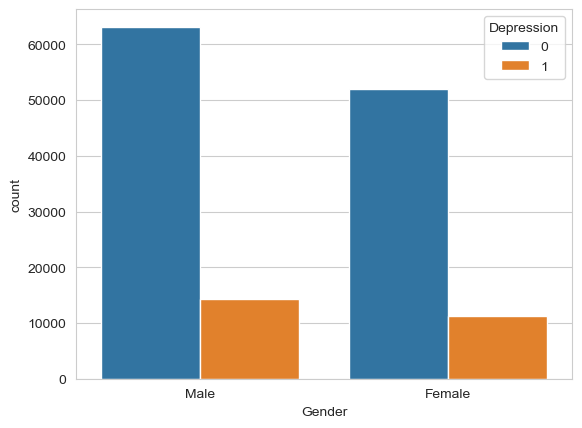

In [40]:
sns.barplot(x='Gender', y='count', hue='Depression', data=group_df)

### Age

In [41]:
group_df = train_data.groupBy('Age', 'Depression').count().toPandas()

In [42]:
age_bins = [18, 25, 35, 45, 50, 70]

In [43]:
group_df['Age'] = pd.cut(group_df['Age'], age_bins, right=False)

In [44]:
group_df = group_df.groupby(['Age', 'Depression'])['count'].sum().reset_index()

<Axes: xlabel='Age', ylabel='count'>

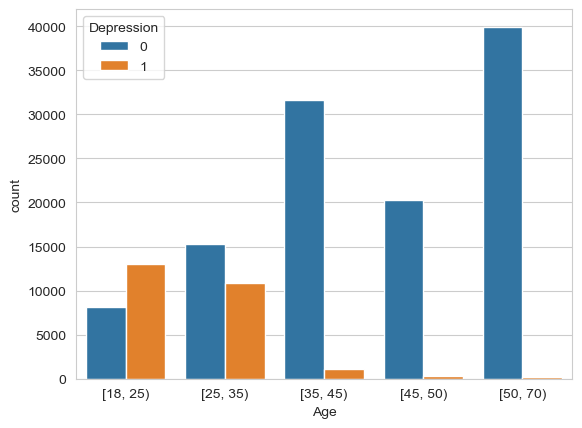

In [45]:
sns.barplot(x='Age', y='count', hue='Depression', data=group_df)

### Status

In [46]:
group_df = train_data.groupBy('Status', 'Depression').count().toPandas()

In [47]:
group_df

,Status,Depression,count
0,Working Professional,1,9231
1,Student,0,11565
2,Student,1,16336
3,Working Professional,0,103568


<Axes: xlabel='Status', ylabel='count'>

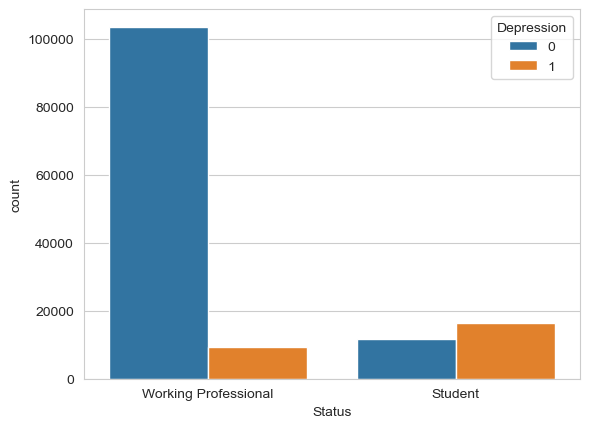

In [48]:
sns.barplot(group_df, x='Status', y='count', hue='Depression')

### Academic Pressure

In [49]:
group_df = train_data.groupBy('Acad_Pressure', 'Depression').count().toPandas()

<Axes: xlabel='Acad_Pressure', ylabel='count'>

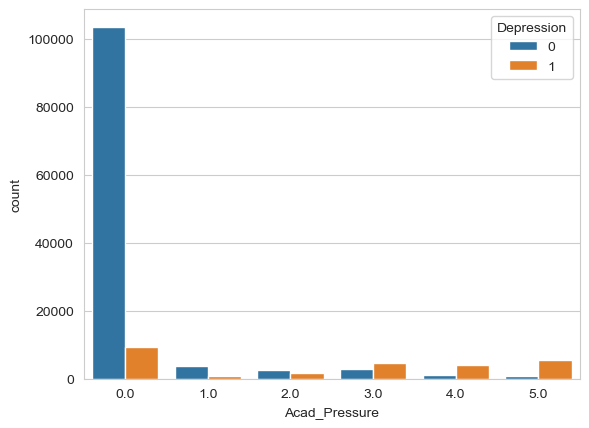

In [50]:
sns.barplot(group_df, x='Acad_Pressure', y='count', hue='Depression')

### Work Pressure

In [51]:
group_df = train_data.groupBy('Work_Pressure', 'Depression').count().toPandas()

<Axes: xlabel='Work_Pressure', ylabel='count'>

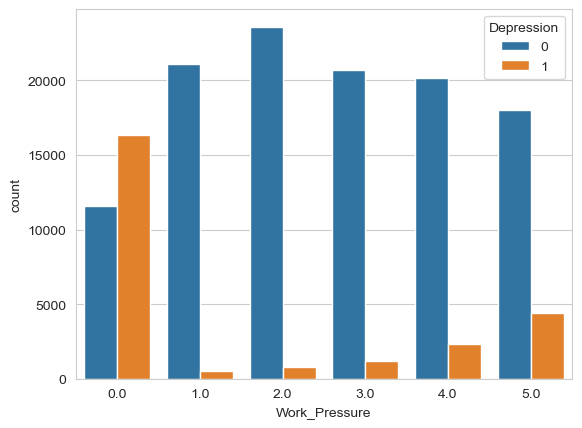

In [52]:
sns.barplot(group_df, x='Work_Pressure', y='count', hue='Depression')

### CGPA

In [53]:
cgpa_bins = train_data.select('CGPA').rdd.flatMap(lambda x: x).histogram(5)[0]

In [54]:
cgpa_bins[-1] += 0.01

In [55]:
group_df = train_data.groupBy('CGPA', 'Depression').count().toPandas()

In [56]:
group_df['CGPA'] = pd.cut(group_df['CGPA'], cgpa_bins, right=False)

<Axes: xlabel='CGPA', ylabel='count'>

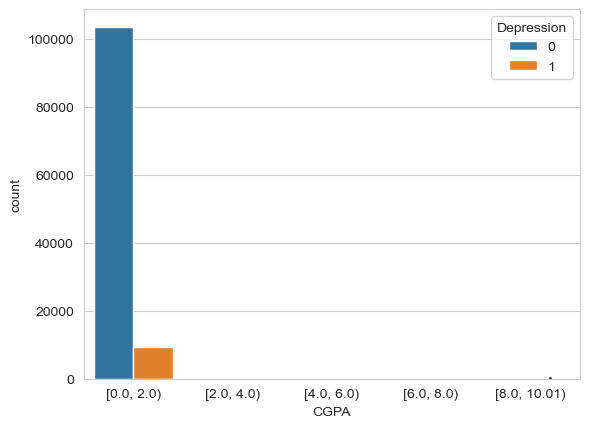

In [57]:
sns.barplot(x='CGPA', y='count', hue='Depression', data=group_df)

<Axes: xlabel='CGPA', ylabel='count'>

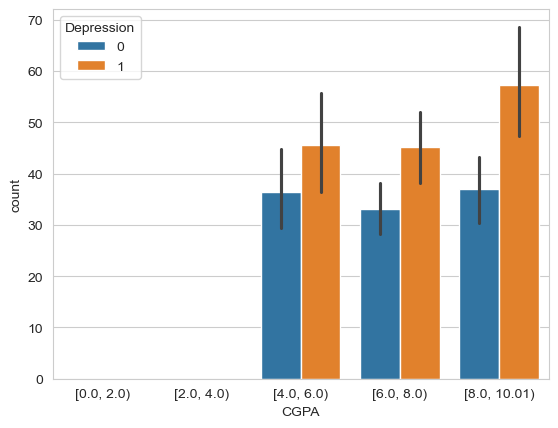

In [58]:
sns.barplot(x='CGPA', y='count', hue='Depression', data = group_df.query('CGPA != [0.0, 2.0]'))

## Pre-processing

In [59]:
num_feats = ['CGPA']
cat_feats = train_data.columns
cat_feats.remove("CGPA")
cat_feats.remove("Depression")

# after indexing
cat_feats_out = list(map(lambda x: x+'_feature', cat_feats))
features = cat_feats_out + num_feats

In [60]:
int_features = ['Age', 'Acad_Pressure', 'Work_Pressure', 'Study_Sat', 'Job_Sat', 'Work_Study_Hours', 'Fin_Stress']
for feature in int_features:
    train_data = train_data.withColumn(feature, col(feature).cast('int'))
    test_data = test_data.withColumn(feature, col(feature).cast('int'))

In [61]:
indxr = StringIndexer(inputCols=cat_feats, outputCols=cat_feats_out, handleInvalid="keep")
indxr = indxr.fit(train_data)

In [62]:
train_data = indxr.transform(train_data)
test_data = indxr.transform(test_data)

In [63]:
asmblr = VectorAssembler(inputCols=features, outputCol='features')

In [64]:
train_data = asmblr.transform(train_data)
test_data = asmblr.transform(test_data)

## Classifier

In [71]:
from pyspark.ml.classification import RandomForestClassifier, GBTClassifier

In [67]:
def models_perf(train):
    train, test = train.randomSplit([0.8, 0.2], 12)

    evaluator = MulticlassClassificationEvaluator(labelCol = 'Depression', metricName = 'accuracy')
    perf = []
    models_name = []

    for i in range(100, 401, 100):
        rf = RandomForestClassifier(maxBins=115, numTrees=i, labelCol='Depression')
        rf = rf.fit(train)
        perf.append(rf.evaluate(test).accuracy)
        models_name.append(f'RF(trees={i})')


    for i in range(100, 201, 100):
        gbt = GBTClassifier(maxBins=115, maxIter=i, labelCol='Depression')
        gbt = gbt.fit(train)
        perf.append(evaluator.evaluate(gbt.transform(test)))
        models_name.append(f'GBT(iters={i})')

    res = pd.DataFrame({'model': models_name,
                        'accuracy': perf})
    return res

In [68]:
models_perf(train_data)

,model,accuracy
0,RF(trees=100),0.923530
1,RF(trees=200),0.919921
2,RF(trees=300),0.919957
3,RF(trees=400),0.921065
4,GBT(iters=100),0.935680
5,GBT(iters=200),0.936001
